In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt


In [2]:
# load data
data = pd.read_csv(
    "~/github/Chinook-Salmon-Research-Project/data/increments_NCC_fall_age_1_2.csv")
data.columns

Index(['Unnamed: 0', 'year', 'stock', 'length', 'SSTarc_summer',
       'SSTarc_winter', 'PDO', 'WA_Pinks', 'ALPI', 'Pinks', 'NPGO',
       'MEI_summer', 'MEI_winter', 'BI'],
      dtype='object')

In [3]:

data_x = data.drop(columns=['Unnamed: 0', 'year','length','stock'], axis=1)
data_y = data[['length']]
data_x

,SSTarc_summer,SSTarc_winter,PDO,WA_Pinks,ALPI,Pinks,NPGO,MEI_summer,MEI_winter,BI
0,0.344474,0.246118,1.495554,-0.799018,2.151431,-1.031130,-0.732847,0.973333,-0.350000,-1.414170
1,0.344474,0.246118,1.495554,-0.799018,2.151431,-1.031130,-0.732847,0.973333,-0.350000,-1.414170
2,0.344474,0.246118,1.495554,-0.799018,2.151431,-1.031130,-0.732847,0.973333,-0.350000,-1.414170
3,-0.181002,0.458551,1.643988,0.193823,1.518919,-0.471888,0.429175,1.543333,1.176667,-0.763411
4,-0.181002,0.458551,1.643988,0.193823,1.518919,-0.471888,0.429175,1.543333,1.176667,-0.763411
...,...,...,...,...,...,...,...,...,...,...
77,2.243629,0.393421,0.972684,-0.799018,-0.158439,0.785994,-0.249174,0.110000,-0.340000,-0.848293
78,2.788084,1.365662,1.389256,0.827555,0.205856,2.192808,-1.394541,1.953333,0.136667,-0.310709
79,2.788084,1.365662,1.389256,0.827555,0.205856,2.192808,-1.394541,1.953333,0.136667,-0.310709
80,2.788084,1.365662,1.389256,0.827555,0.205856,2.192808,-1.394541,1.953333,0.136667,-0.310709


In [4]:
# run random forest on all the data 
from sklearn.ensemble import RandomForestRegressor
#,max_depth = 2, max_features=3
rf = RandomForestRegressor(n_estimators = 500, random_state = 42, max_depth=2)
mod1 = rf.fit(data_x,data_y)

<ipython-input-4-a02d879ee352>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod1 = rf.fit(data_x,data_y)


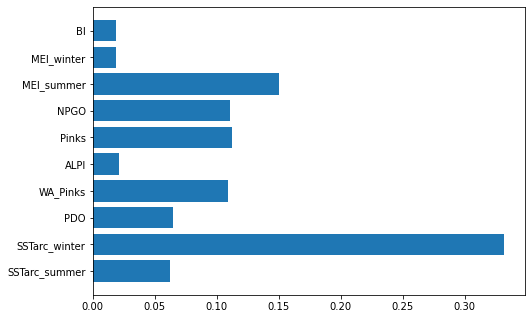

In [5]:
# get quantities from model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(data_x.columns,mod1.feature_importances_)
plt.show()

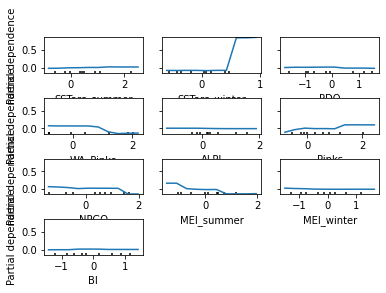

In [12]:
# code for partial effect plots is from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

display = plot_partial_dependence(
       mod1, data_x, data_x.columns[0:10], n_jobs = 3, grid_resolution = 10, 
)

display.figure_.subplots_adjust(hspace=0.7)

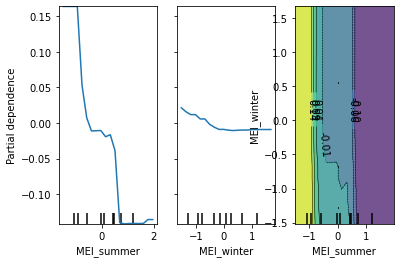

In [13]:
display = plot_partial_dependence(
       mod1, data_x, [7,8,(7,8)], n_jobs = 3, grid_resolution = 20, 
)

display.figure_.subplots_adjust(hspace=0.7)

<ipython-input-10-c3d0b0236183>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod_2 = rf.fit(train_x,train_y)
<ipython-input-10-c3d0b0236183>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod_2 = rf.fit(train_x,train_y)
<ipython-input-10-c3d0b0236183>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod_2 = rf.fit(train_x,train_y)
<ipython-input-10-c3d0b0236183>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mod_2 = rf.fit(train_x,train_y)
<ipython-input-10-c3d0b0236183>:12: DataConversionWarning: A column-vector y was passed when a 1d ar

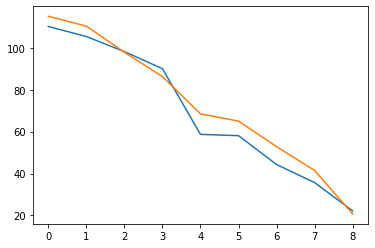

In [10]:
# run leave future out CV
score = []
means = []
r2_ls = []
for i in range(2005,2014):
  train = data[data.year < i]
  test = data[data.year > (i-1)]
  test_y = test[['length']]
  test_x = test.drop(columns=['Unnamed: 0', 'year','length','stock'], axis=1)
  train_y = train[['length']]
  train_x = train.drop(columns=['Unnamed: 0', 'year','length','stock'], axis=1)
  mod_2 = rf.fit(train_x,train_y)
  val = ((test_y.to_numpy().transpose()[0] - mod_2.predict(test_x))**2).sum()
  val_mean = ((test_y.to_numpy().transpose()[0] - train_y.to_numpy().transpose()[0].sum()/len(train_y.to_numpy().transpose()[0]))**2).sum()
  score.append(val)
  means.append(val_mean)
  val = (abs(test_y.to_numpy().transpose()[0] - mod_2.predict(test_x))).sum()
  val_mean = (abs(test_y.to_numpy().transpose()[0] - train_y.to_numpy().transpose()[0].sum()/len(train_y.to_numpy().transpose()[0]))).sum()
  r2 = (val_mean - val)/val_mean
  r2_ls.append(r2)



plt.plot(score)
plt.plot(means)

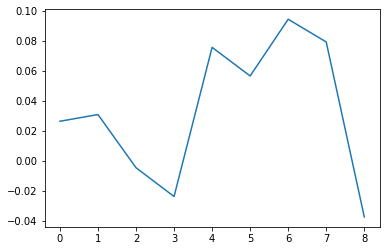

In [11]:
plt.plot(r2_ls)